# Recurrent Neural Networks

Prerequisites:

* Tensorflow + keras
* CNN 1D

Outcomes:

* Understand the ideas behind recurrent neural networks
* Apply recurrent neural networks to inflation prediction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

%matplotlib inline

## Data

Many types of data are inherently sequential. The most common type of sequential data that you'll encounter is time-series data, but text data could also be viewed as "sequential data" since the words have an ordering to them.

Today's lecture will focus primarily on time-series data, but these methods could be applied to other kinds of sequential data.

**Today's data**

We are loosely going to follow some of the work done in ["Predicting Inflation with Neural Networks"](https://warwick.ac.uk/fac/soc/economics/research/workingpapers/2021/twerp_1344_-_paranhos.pdf) by [Livia Paranhos](https://sites.google.com/view/livia-paranhos/research). Livia is a current PhD student at University of Warwick -- The tools we're discussing today are being actively applied by PhD students to do research!

In her paper, she uses 100+ macroeconomic variables from the FRED database as collected by McCracken Ng (2016) to predict inflation in a variety of settings.

We are going to use a subset of the data that she uses to simplify our exposition, but we recommend skimming her paper or her slides to see how she used the larger dataset.

In particular, we use:

* `RPI`: Real personal income
* `UNRATE`: Civilian unemployment rate
* `PAYEMS`: Total civilian nonfarm employment
* `TB3MS`: The three month treasury bill rate
* `CPIAUCSL`: The consumer price index for all goods
* `SP500`: The S&P 500 index price

In [2]:
variables = [
    "RPI", "UNRATE", "PAYEMS",
    "TB3MS", "CPIAUCSL", "S&P 500"
]

data_url = "https://files.stlouisfed.org/"
data_url += "files/htdocs/fred-md/monthly/2019-01.csv"
data = pd.read_csv(data_url).iloc[1:, :]

data["dt"] = pd.to_datetime(data["sasdate"])

data = data.set_index("dt").loc[:, variables].dropna()

In [3]:
data.head()

,RPI,UNRATE,PAYEMS,TB3MS,CPIAUCSL,S&P 500
dt,,,,,,
1959-01-01,2437.296,6.0,52480,2.82,29.01,55.62
1959-02-01,2446.902,5.9,52687,2.70,29.00,54.77
1959-03-01,2462.689,5.6,53016,2.80,28.97,56.16
1959-04-01,2478.744,5.2,53320,2.95,28.98,57.10
1959-05-01,2493.228,5.1,53549,2.84,29.04,57.96


Once we've downloaded the data, we're going to perform some typical transformations:


In [4]:
diff = lambda x: x.diff(12)
log_diff = lambda x: 100*np.log(x).diff(12)

df = data.transform(
    {
        "RPI": log_diff,
        "UNRATE": diff,
        "PAYEMS": log_diff,
        "TB3MS": diff,
        "CPIAUCSL": log_diff,
        "S&P 500": log_diff
    }
).dropna().loc["1970":, :]

In [5]:
df.describe()

,RPI,UNRATE,PAYEMS,TB3MS,CPIAUCSL,S&P 500
count,587.000000,587.000000,587.000000,587.000000,587.000000,587.000000
mean,2.860134,0.008518,1.526735,-0.098433,3.929304,6.822759
std,2.001215,1.105847,1.852500,1.780846,2.798356,16.055367
min,-5.059679,-2.900000,-5.089415,-6.830000,-1.978199,-55.353117
25%,1.783093,-0.700000,0.543529,-0.980000,2.137630,-0.480560
50%,2.999605,-0.300000,1.761091,-0.040000,3.144014,9.699064
75%,4.092675,0.400000,2.569615,0.940000,4.797520,17.699322
max,8.476949,4.000000,5.295946,7.720000,13.621020,42.298292


**Training, validation, and test data**

We'll use a 70%-20%-10% split for the data



In [6]:
n = df.shape[0]

# Training data
train_n = int(n*0.7)
train_df = df.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.2)
val_df = df.iloc[train_n:train_n+val_n, :]

# Testing data
test_df = df.iloc[train_n+val_n:, :]

**Normalize the data**

It is typical to modify our data to have mean 0 and standard deviation 1.

We do this to the training data and then use the mean and standard deviation of the _training data_ to modify the validation and testing data

In [7]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

<AxesSubplot:xlabel='dt'>

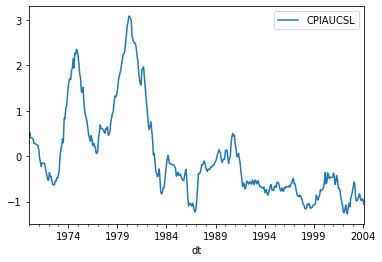

In [8]:
train_df.plot(y="CPIAUCSL")

<AxesSubplot:xlabel='dt'>

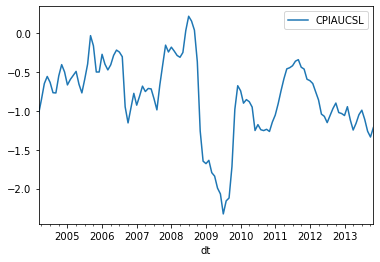

In [9]:
val_df.plot(y="CPIAUCSL")

<AxesSubplot:xlabel='dt'>

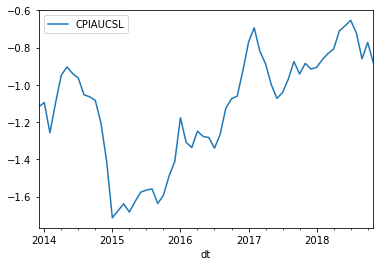

In [10]:
test_df.plot(y="CPIAUCSL")

**Helper classes and functions**

Follow the ideas in https://www.tensorflow.org/tutorials/structured_data/time_series and create a few helpers

In [11]:
class WindowGenerator():

    def __init__(
        self, input_width, label_width, shift,
        train_df=train_df, val_df=val_df, test_df=test_df,
        label_columns=None
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {
            name: i for i, name in enumerate(train_df.columns)
        }

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join(
            [
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ], axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='CPIAUCSL', max_subplots=3):
    
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices, predictions[n, :, 0],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64
                )

            if n == 0:
                plt.legend()

        plt.xlabel('Months')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=24,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result

        return result

In [12]:
INPUT_WIDTH = 24
LABEL_WIDTH = 1
SHIFT = 1

eval_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
    shift=SHIFT, label_columns=["CPIAUCSL"]
)

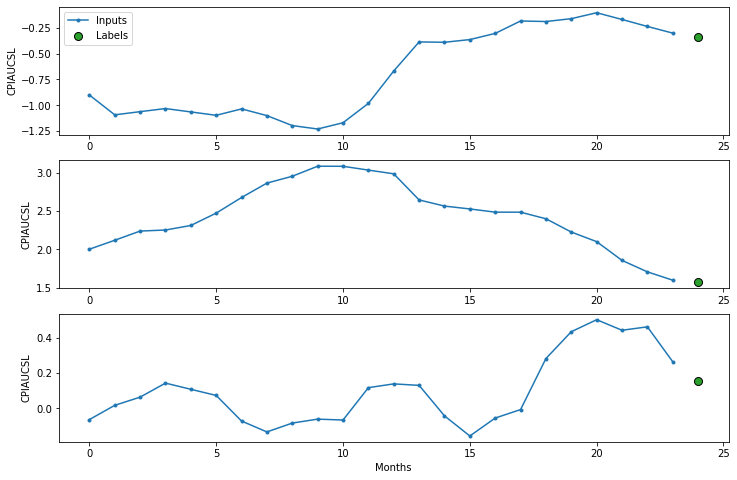

In [13]:
eval_window.plot(max_subplots=3)

In [14]:
MAX_EPOCHS = 250

def compile_and_fit(model, window, patience=5):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.RMSprop(),
    )


    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

**A simple prediction method**

Domain expertise often can be used to create a "baseline" prediction model. For example,

* The high temperature today could be somewhat accurately predicted by yesterday's high temperature.
* The price of a stock today could be somewhat accurately predicted by the price of the stock yesterday.
* U.S. annual inflation can somewhat accurately be predicted with a constant guess of 2%

It's important to understand what baseline models are on the table because a simple baseline model will sometimes outperform a complex machine learning model (and when it does, we shouldn't be afraid to turn to the simple model)

_Our baseline model_

Predict a mixture of 0 (the mean that we normalized to) and the previous value:

$$\pi_t = (1 - \gamma) 0.0 + \gamma \pi_{t-1}$$

In [15]:
class BaselineInflation(tf.keras.Model):
    def __init__(self, gamma=0.9, label_index=None):
        super().__init__()
        self.gamma = gamma
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            x = self.gamma*inputs + (1-self.gamma)*0
        else:
            x = self.gamma*inputs[:, :, self.label_index] + (1-self.gamma)*0

        return x[:, :, tf.newaxis]

In [16]:
baseline = BaselineInflation(gamma=0.9, label_index=eval_window.column_indices["CPIAUCSL"])
baseline.compile(loss=tf.losses.MeanSquaredError())

val_performance = {}
performance = {}

val_performance['Baseline'] = baseline.evaluate(eval_window.val)
performance['Baseline'] = baseline.evaluate(eval_window.test, verbose=0)

4/4 [==============================] - 0s 3ms/step - loss: 0.4902


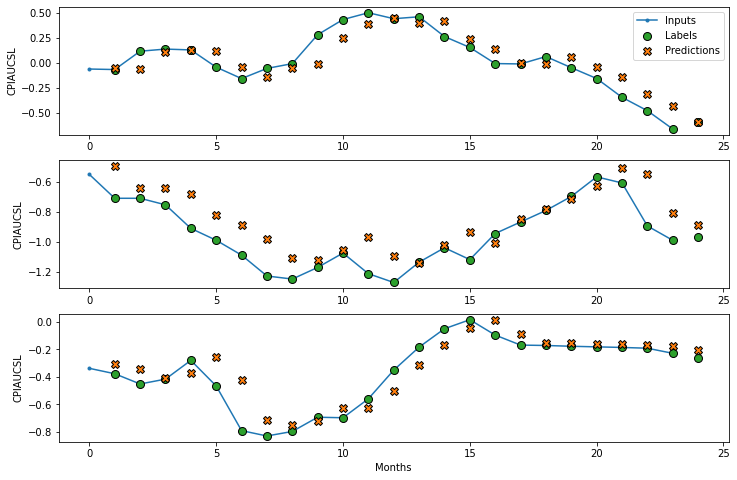

In [17]:
wide_window_baseline = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=INPUT_WIDTH,
    shift=SHIFT, label_columns=["CPIAUCSL"]
)

wide_window_baseline.plot(baseline, max_subplots=3)

## Review: 1D CNN

### Defining a 1D CNN

Given hyper parameters,

* $K$: Number of filters
* $F$: Window width
* $S$: Stride
* $P$: Padding

Let $w \in \mathbb{R}^K$ be the filter weights and $b \in \mathbb{R}$ be the bias.

Output $i$ for a particular filter is defined by:

$$z_i = \left( \sum_{j=0}^F w_{j} x_{i + j - F//2} \right) + b$$

In [18]:
def conv1d(x, w, b, S=1, P=0):
    """
    Apply single filter of 1d Convolution to x given
    filter weights (w), bias (b), stride (S), and padding (P)
    """
    assert P >= 0
    if P == 0:
        x_pad = x
    else:
        x_pad = np.concatenate([np.zeros(P), x, np.zeros(P)])
    N = len(x)
    F = len(w)
    half_F = F // 2
    out = []
    for i in range(half_F, len(x_pad) - half_F, S):
        window = x_pad[(i-half_F):(i+half_F + 1)]    
        out.append((w @ window) + b)

    return out

### Predicting our data with a 1D CNN

In [19]:
CONV_WIDTH = 12

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)

conv_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters=8, kernel_size=(CONV_WIDTH,), activation="relu"),
        tf.keras.layers.Dense(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model, conv_window)

val_performance['Conv1D'] = conv_model.evaluate(eval_window.val)
performance['Conv1D'] = conv_model.evaluate(eval_window.test, verbose=0)

Epoch 1/250
17/17 [==============================] - 1s 15ms/step - loss: 1.0351 - val_loss: 1.5349
Epoch 2/250
17/17 [==============================] - 0s 9ms/step - loss: 0.9683 - val_loss: 1.4650
Epoch 3/250
17/17 [==============================] - 0s 8ms/step - loss: 0.9469 - val_loss: 1.4228
Epoch 4/250
17/17 [==============================] - 0s 10ms/step - loss: 0.9345 - val_loss: 1.3945
Epoch 5/250
17/17 [==============================] - 0s 18ms/step - loss: 0.9268 - val_loss: 1.3755
Epoch 6/250
17/17 [==============================] - 0s 8ms/step - loss: 0.9195 - val_loss: 1.3570
Epoch 7/250
17/17 [==============================] - 0s 9ms/step - loss: 0.9133 - val_loss: 1.3379
Epoch 8/250
17/17 [==============================] - 0s 11ms/step - loss: 0.9064 - val_loss: 1.3159
Epoch 9/250
17/17 [==============================] - 0s 18ms/step - loss: 0.8987 - val_loss: 1.2929
Epoch 10/250
17/17 [==============================] - 0s 10ms/step - loss: 0.8918 - val_loss: 1.2649
Epo

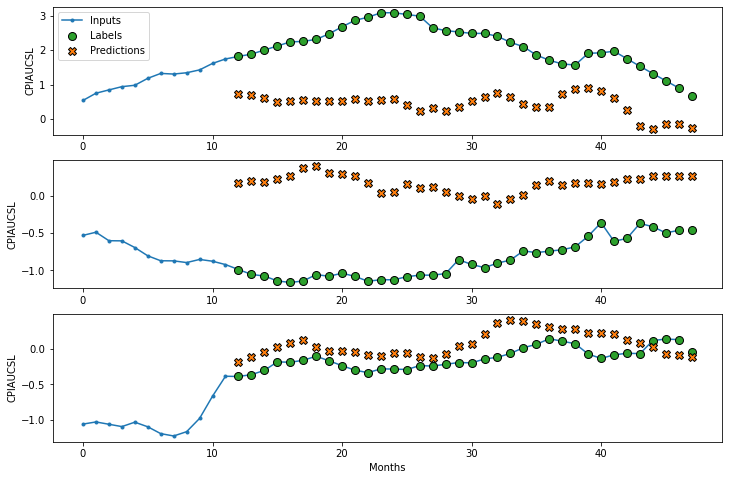

In [20]:
wide_window_conv = WindowGenerator(
    input_width=36 + (CONV_WIDTH - 1),
    label_width=36,
    shift=SHIFT
)

wide_window_conv.plot(conv_model, max_subplots=3)

In [21]:
val_performance

{'Baseline': 0.49024951457977295, 'Conv1D': 0.48369383811950684}

## Recurrent Neural Networks

Similar to 1D CNNs, recurrent neural networks (RNNs) deal with sequentially ordered data.

However, unlike CNNS, they can maintain a "memory" from beyond the current window/observation. Many people liken this internal memory to "identifying a hidden state".

### Simple RNN

We begin by considering the most basic version of an RNN which we refer to as the "simple RNN"

The output for step $t$ is given by:

\begin{align*}
  h_t &= \sigma_h(W_h x_t + U_h h_{t-1} + b_h) \\
  y_t &= \sigma_y(W_y h_t + b_y) \\
\end{align*}

**Simple RNN "by hand"**

In [ ]:
timesteps = 100
input_features = 32
output_features = 64

inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
W_y = np.random.random((1, output_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features))
b_y = 0.0

successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    y_t = np.tanh(np.dot(W_y, output_t) + b_y)
    successive_outputs.append(output_t)
    state_t = output_t

final_output_sequence = np.concatenate(successive_outputs, axis=0)

**Using tensorflow**

Let's turn to our predicting inflation problem and write a simple RNN using Tensorflow

In [ ]:
srnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.SimpleRNN(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(srnn_model, eval_window)

val_performance['SimpleRNN'] = srnn_model.evaluate(eval_window.val)
performance['SimpleRNN'] = srnn_model.evaluate(eval_window.test, verbose=0)

In [ ]:
performance

### LSTM and GRU

Similar to some of the problems we ran into when we had too many layers in our neural networks, simple RNNs often run into the [vanishing gradient problem and exploding gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).

There have been two solutions proposed to address this concern:

* Long short-term memory (LSTM), Hochreiter and Schmidhuber 1997
* Gated recurrent unit (GRU), Cho et al. 2014

**LSTM**

LSTM introduces the notion of a "carry state".

Output for step $t$ is now given by:

$$h_t = \sigma_h(W_h x_t + U_h h_{t-1} + V_h c_t + b_h)$$

where $c_t$ is computed with

\begin{align*}
  c_{t+1} &= i_t k_t + c_t f_t \\
  i_t &= \sigma(U_i \hat{x}_{t} + W_i x_t + b_i) \\
  f_t &= \sigma(U_f \hat{x}_{t} + W_f x_t + b_f) \\
  k_t &= \sigma(U_k \hat{x}_{t} + W_k x_t + b_k) \\
\end{align*}

Conceptually, this doesn't add a significant amount of complexity, but it does require more work from your computer.

In [ ]:
lstm_model = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(lstm_model, eval_window)

val_performance['LSTM'] = lstm_model.evaluate(eval_window.val)
performance['LSTM'] = lstm_model.evaluate(eval_window.test, verbose=0)

In [ ]:
performance

In [ ]:
val_performance

**GRU**

GRU is similar to the LSTM framework but is computationally slightly simpler. The pro is that this means it typically will run faster than LSTM but the drawback is that it can perform slightly worse.

Output for step $t$ is given by:

\begin{align*}
  z_t &= \sigma_g(W_z x_t + U_z h_{t-1} + b_z) \\
  r_t &= \sigma_g(W_r x_t + U_r h_{t-1} + b_r) \\
  \hat{h}_t &= \phi_h(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h) \\
  h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \hat{h}_{t}
\end{align*}

In [ ]:
gru_model = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(gru_model, eval_window)

val_performance['GRU'] = gru_model.evaluate(eval_window.val)
performance['GRU'] = gru_model.evaluate(eval_window.test, verbose=0)

In [ ]:
val_performance

### Stacking RNNs

The convenient interface of Keras allows us to stack a variety of layers with one another. This includes using multiple levels of RNNs!

In [ ]:
performance

In [ ]:
stacked_model = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=True),
        tf.keras.layers.GRU(4, activation="tanh", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(stacked_model, eval_window, patience=25)

val_performance['stacked'] = stacked_model.evaluate(eval_window.val)
performance['stacked'] = stacked_model.evaluate(eval_window.test, verbose=0)

## Combining 1D CNNs with RNNs

A recommendation that is made in a few places is that CNNs and RNNs can be combined effectively. In "Deep Learning with Python", Francis Chollet makes the following observation,

> Because 1D convnets process input patches independently, they aren't sensitive to the order of the timesteps (beyond a local scale...), unlike RNNs...
>
>One strategy to combine the speed and lightness of convnets with the order-sensitivity of RNNs is to use a 1D convnet as a preprocessing step before an RNN. This is especially beneficial when you're dealing with sequences that are so long that they can't realistically be processed with RNNs, such as sequences with thousands of steps. The convnet will turn the long input sequence into mcuh shorter sequences of higher-level features...
>
>This technique isn't seen often in research papers and practical applications possibly because it isn't well known. It's effective and ought to be more common.

In [ ]:
CONV_WIDTH = 6

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)

conv_rnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters=4, kernel_size=(CONV_WIDTH,), activation="tanh"),
        tf.keras.layers.GRU(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_rnn_model, conv_window, patience=25)

val_performance['Conv+RNN'] = conv_rnn_model.evaluate(eval_window.val)
performance['Conv+RNN'] = conv_rnn_model.evaluate(eval_window.test, verbose=0)

In [ ]:
performance

## Additional resources

* https://towardsdatascience.com/recurrent-neural-networks-for-recession-forecast-f435a2a4f3ef
* https://medium.com/microsoftazure/neural-networks-for-forecasting-financial-and-economic-time-series-6aca370ff412
* https://www.tensorflow.org/guide/keras/rnn
* https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network